In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#Web Scraping
from bs4 import BeautifulSoup
import requests

from IPython.display import display, Image

#.rar
import patoolib

from difflib import SequenceMatcher

from datetime import timedelta, date

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

# Gathering Data

In [2]:
data_prov = pd.read_csv("https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv", keep_default_na=False)
df_prov = data_prov[["fecha", "provincia_iso", "num_casos"]].copy()
df_prov.columns = ["Fecha", "Provincia", "Casos"]
df_prov["Fecha"] = pd.to_datetime(df_prov["Fecha"], format='%Y-%m-%d')
df_prov.head()

,Fecha,Provincia,Casos
0,2020-01-01,A,0
1,2020-01-01,AB,0
2,2020-01-01,AL,0
3,2020-01-01,AV,0
4,2020-01-01,B,1


In [3]:
url = "https://es.wikipedia.org/wiki/ISO_3166-2:ES"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

iso = [letters.get_text().split("-")[1] for letters in soup.select("#mw-content-text > div.mw-parser-output > table:nth-child(11) > tbody > tr > td > tt")]
provinces = [provincia.get_text() for provincia in soup.select("#mw-content-text > div.mw-parser-output > table:nth-child(11) > tbody > tr > td > a")]
comunidadiso = provinces[1::2]
comunidadiso.append("CE")
comunidadiso.append("ME")
del provinces[1::2]

print(len(comunidadiso))
iso.append("CE")
iso.append("ME")
provinces.append("Ceuta")
provinces.append("Melilla")

isotoprov = {iso[i]: provinces[i] for i in range(len(iso))} 
provtoiso = {provinces[i]: iso[i] for i in range(len(iso))}

52


In [4]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [5]:
def Consistent_Provinces(x, keys):
    if "/" in x:
        x = x.split("/")[1]

    similar_index = [similar(key,x) for key in keys]
    return keys[similar_index.index(max(similar_index))]

In [6]:
data_fases = pd.read_csv("Fases Deescalada.csv", keep_default_na=False)
df_fases = data_fases[["Fecha", "provinces", "iso", "comunidadiso", "Fase"]].copy().drop("provinces", axis = 1)
df_fases.columns = ["Fecha", "Provincia", "Comunidadiso", "Fase"]
df_fases["Fecha"] = pd.to_datetime(df_fases["Fecha"], format='%d/%m/%Y')
df_fases.head()

,Fecha,Provincia,Comunidadiso,Fase
0,2020-03-14,C,GA,EDA
1,2020-03-14,VI,PV,EDA
2,2020-03-14,AB,CM,EDA
3,2020-03-14,A,VC,EDA
4,2020-03-14,AL,AN,EDA


In [7]:
data_pob = pd.read_excel("Poblacion por provincia.xls", header =8)
df_pob = data_pob.copy()
df_pob.columns = ["Provincia", "Poblacion"]
df_pob = df_pob[:-8]
df_pob["Provincia"] = df_pob["Provincia"].apply(lambda x: x[3:])
df_pob["Provincia"] = df_pob["Provincia"].apply(lambda x: Consistent_Provinces(x, keys = list(provtoiso.keys()))).replace(to_replace = provtoiso, inplace = False)
df_pob["Poblacion"] = df_pob["Poblacion"].astype(int)
df_pob.head(52)


,Provincia,Poblacion
0,AB,388167
1,A,1858683
2,AL,716820
3,VI,331549
4,O,1022800
5,AV,157640
6,BA,673559
7,PM,1149460
8,B,5664579
9,BI,1152651


# Transforming Data

In [8]:
def clean_fase(x):
    if x == "EDA":
        return 1
    elif x == "0":
        return 2
    elif x == "1":
        return 3
    elif x == "2":
        return 4
    elif x == "3":
        return 5
    elif x == "4":
        return 6

In [9]:
def join_fases(df_prov, df_fases):
    df = df_prov.copy()
    df["Fase"] = np.nan
    
    mask = df['Fecha'] < df_fases["Fecha"].unique()[0]
    df.loc[mask, "Fase"] = df.loc[mask, "Fase"].apply(lambda x: 0)
    
    for i in range(1,len(df_fases["Fecha"].unique())-1):
        mask_df = (df['Fecha'] >= df_fases["Fecha"].unique()[i-1]) & (df['Fecha'] < df_fases["Fecha"].unique()[i])
        mask_fase = df_fases["Fecha"] == df_fases["Fecha"].unique()[i-1] 
        df.loc[mask_df] = df_prov.loc[mask_df].merge(df_fases.loc[mask_fase, ["Provincia", "Fase"]], on = ["Provincia"], how = "left" )
        
        
    mask = df['Fecha'] > df_fases["Fecha"].unique()[-1]
    df.loc[mask, "Fase"] = df.loc[mask, "Fase"].apply(lambda x: 7)
    
    return df

In [10]:
def join_fases(df_prov, df_fases):
    df = df_prov.copy()
    df["Fase"] = np.nan
    
    mask = df['Fecha'] < df_fases["Fecha"].unique()[0]
    df.loc[mask, "Fase"] = df.loc[mask, "Fase"].apply(lambda x: 0)
    
    for i in range(1,len(df_fases["Fecha"].unique())):
        mask_df = (df['Fecha'] >= df_fases["Fecha"].unique()[i-1]) & (df['Fecha'] < df_fases["Fecha"].unique()[i])
        mask_fase = df_fases["Fecha"] == df_fases["Fecha"].unique()[i-1] 
        dfslice = df_prov.loc[mask_df].merge(df_fases.loc[mask_fase, ["Provincia", "Fase"]], on = ["Provincia"], how = "left" ).copy()
        df.loc[mask_df, "Fase"] = list(dfslice["Fase"])
        
    mask = df['Fecha'] >= df_fases["Fecha"].unique()[-1]
    df.loc[mask, "Fase"] = df.loc[mask, "Fase"].apply(lambda x: 6)
    
    mask = df['Fecha'] >= "2020-10-25"
    df.loc[mask, "Fase"] = df.loc[mask, "Fase"].apply(lambda x: 7)
    return df

In [11]:
def pob_cleaner(data_pob):
    data_pob = pd.read_excel("Poblacion por provincia.xls", header=8)
    df_pob = data_pob.copy()
    df_pob.columns = ["Provincia", "Poblacion"]
    df_pob = df_pob[:-8]
    df_pob["Provincia"] = df_pob["Provincia"].apply(lambda x: x[3:])
    df_pob["Provincia"] = df_pob["Provincia"].apply(lambda x: Consistent_Provinces(x, keys = list(provtoiso.keys()))).replace(to_replace = provtoiso, inplace = False)
    df_pob["Poblacion"] = df_pob["Poblacion"].astype(int)
    return df_pob

In [12]:
df_fases["Fase"] = df_fases["Fase"].apply(clean_fase)

In [13]:
df = join_fases(df_prov, df_fases)
df.head(52)

,Fecha,Provincia,Casos,Fase
0,2020-01-01,A,0,0.0
1,2020-01-01,AB,0,0.0
2,2020-01-01,AL,0,0.0
3,2020-01-01,AV,0,0.0
4,2020-01-01,B,1,0.0
5,2020-01-01,BA,0,0.0
6,2020-01-01,BI,0,0.0
7,2020-01-01,BU,0,0.0
8,2020-01-01,C,0,0.0
9,2020-01-01,CA,0,0.0


In [14]:
#df.loc[df.A!='a','A'].index[0]
#Find first

In [15]:
df = df.merge(df_pob, on = "Provincia", how = "left")
df.head(52)

,Fecha,Provincia,Casos,Fase,Poblacion
0,2020-01-01,A,0,0.0,1858683
1,2020-01-01,AB,0,0.0,388167
2,2020-01-01,AL,0,0.0,716820
3,2020-01-01,AV,0,0.0,157640
4,2020-01-01,B,1,0.0,5664579
5,2020-01-01,BA,0,0.0,673559
6,2020-01-01,BI,0,0.0,1152651
7,2020-01-01,BU,0,0.0,356958
8,2020-01-01,C,0,0.0,1119596
9,2020-01-01,CA,0,0.0,1240155


In [16]:
df["Nombre"] = list(df["Provincia"].map(isotoprov))
df.head()

,Fecha,Provincia,Casos,Fase,Poblacion,Nombre
0,2020-01-01,A,0,0.0,1858683,Alicante
1,2020-01-01,AB,0,0.0,388167,Albacete
2,2020-01-01,AL,0,0.0,716820,Almería
3,2020-01-01,AV,0,0.0,157640,Ávila
4,2020-01-01,B,1,0.0,5664579,Barcelona


# SIR Model

In [17]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [18]:
def deriv(y0, t, N, beta, gamma): #The SIR model differential equations.
    S, I, R = y0
    dSdt = -beta * S * I / N + gamma * I *0.057
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I *0.943
    return dSdt, dIdt, dRdt

#ret = odeint(deriv, y0, t, args=(N, beta, gamma))
#S, I, R= ret.T

In [19]:
def SIR_basic(N, I0, R0, gamma, beta, t):
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    t = np.linspace(0, t, t)
    
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R= ret.T
    
    v = t, S, I, R
    return t, S, I, R
model = SIR_basic(N=4700, I0=1, R0=0, gamma=1./9, beta = 0.4, t=100)

In [20]:
def SIR_run(N, S0, I0, R0, gamma, beta, t):
    y0 = S0, I0, R0
    N = S0 + I0 + R0
    t = np.linspace(0, t, t)
    
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R= ret.T
    
    v = t, S, I, R
    return t, S, I, R

In [21]:
def plotseird(t=None, S=None, I=None, R=None, v=None):
    if v is not None:
        t, S, I, R = v
        
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.plot(t, S+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
    #plt.title("Lockdown after {} days".format(L))
        
    R0 = None
    if R0 is not None:
        f = plt.figure(figsize=(12,4))
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    plt.show();

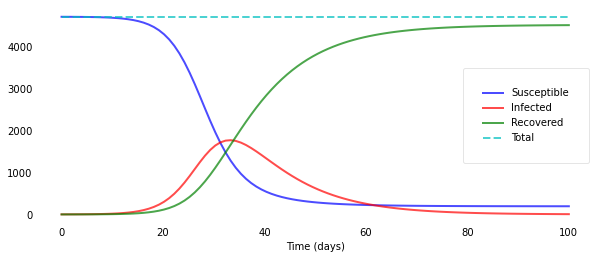

In [22]:
plotseird(v = model)

# Fitting SIR Model

In [23]:
def fase_cutter(provdf):
    faselist = []
    for i in range(8):
        fase = provdf.loc[provdf["Fase"] == i].reset_index(drop=True)
        if len(fase) > 0:
            faselist.append(provdf.loc[provdf["Fase"] == i].reset_index(drop=True))
    return faselist

In [24]:
def beta_optimizer(It, N, I0, R0, gamma, t, S0=None):
    beta_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    MAE = []
    for i in range(len(beta_values)):
        if S0 is None:
            lintime, S, Ip, R = SIR_basic(N, I0, R0, gamma, beta_values[i], t)
        else:
            lintime, S, Ip, R = SIR_run(N, S0, I0, R0, gamma, beta_values[i], t)
        MAE.append(mae(It, Ip))
        
    true_beta = beta_values[MAE.index(min(MAE))]
    return true_beta, S, R
    

In [32]:
def initial_prams(provdf):
    #t = (df["Fecha"].iloc[-1][-1]-df["Fecha"][0]).days
    #It = df["Casos"].values
    N = provdf["Poblacion"][0]
    I0 = 1 # provdf["Casos"].iloc[provdf.loc[provdf["Casos"] != 0].index[0]]
    R0 = 0
    return N, I0, R0
    
    

In [26]:
def running_params(provdf_fase):
    I0 = provdf_fase["Casos"][0]
    if I0 == 0:
        I0 = 1
    return I0

In [27]:
def time_finder(provdf_fase):
    start = provdf_fase["Fecha"][0]
    end = provdf_fase["Fecha"].iloc[-1]
    return int((end-start).days +1)

In [28]:
def beta_finder(provdf):
    faselist = fase_cutter(provdf)
    betas = []
    
    N, I0, R0 = initial_prams(provdf)
    gamma = 1./4
    t = time_finder(faselist[0])
    It = faselist[0]["Casos"].values
    
    betafound, Sp, Rp = beta_optimizer(It, N, I0, R0, gamma, t)
    betas.append(betafound)
    faselist[0]["Beta"] = betafound
    
    for i in range(1, len(faselist)):
        try:
            I0 = running_params(faselist[i])
            t = time_finder(faselist[i])
            It = faselist[i]["Casos"].values
            betafound, Sp, Rp = beta_optimizer(It, N, I0, Rp[-1], gamma, t, Sp[-1])
            faselist[i]["Beta"] = betafound
        except:
            pass
        
    return faselist, Sp, Rp
    


In [41]:
listofdfprov = []
provtoSp = {}
provtoRp = {}

for prov in df["Nombre"].unique():   
    provdf = df.loc[df["Nombre"]==prov].copy()
    faselist, Sp, Rp = beta_finder(provdf.reset_index(drop=True))
    provtoSp[prov]= Sp[-1]
    provtoRp[prov]= Sp[-1]
    listofdfprov.append(pd.concat(faselist))
df_new = pd.concat(listofdfprov)

In [42]:
df_new = df_new.sort_values(by = "Fecha")
df_new.head()

,Fecha,Provincia,Casos,Fase,Poblacion,Nombre,Beta
0,2020-01-01,A,0,0.0,1858683,Alicante,0.05
0,2020-01-01,HU,0,0.0,220461,Huesca,0.05
0,2020-01-01,H,0,0.0,521870,Huelva,0.05
0,2020-01-01,GU,0,0.0,257762,Guadalajara,0.05
0,2020-01-01,GR,0,0.0,914678,Granada,0.05


Predict a Province
Select a province Madrid


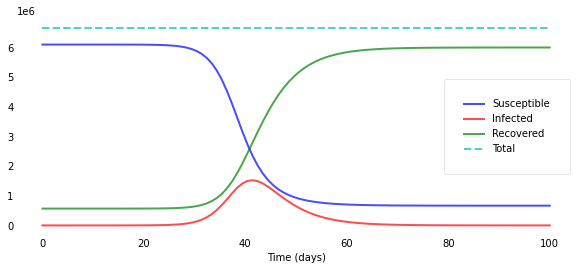

Predict a Province


KeyboardInterrupt: Interrupted by user

In [52]:
while True:
    print("Predict a Province")
    select = str(input("Select a province "))
    provdf = df_new.loc[df_new["Nombre"] == select].copy().reset_index(drop=True)
    N = provdf["Poblacion"][0]
    S = provtoSp[select]
    I = provdf["Casos"].iloc[-1]
    if I <1:
        I = 1
    R = provtoRp[select]
    beta = provdf["Beta"].iloc[-1]
    gamma = 1./4
    t = 100
    model = SIR_basic(N, I, R, gamma, beta, t)
    plotseird(v = model)